# Showing the endpoints of single stars for differen Z and M ZAMS

re-scaling the y-axis to represent a Salpeter IMF

In [1]:
import h5py as h5
import pandas as pd
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

from astropy.table import Table
import sys
sys.path.append('run_data')
from definitions import sim_flags_dict

import os
home_dir = os.path.expanduser("~")

from subprocess import Popen, PIPE
import subprocess

######################################
## PLOT setttings
plt.rc('font', family='serif')
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('text', usetex=False)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,18,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

#################################################################
##   Parameters to set
################################################################# M_ZAMS_Type_perZ_NewWinds_RemFryer2012
home_dir = os.path.expanduser("~") 
Zenodo_data_dir = f'{home_dir}/ceph/CompasOutput/Zenodo_vanSon2024' # change to your local path
root_out_dir    = Zenodo_data_dir

# Run/load your grid of effectively single stars 

In [2]:
#################################################################
##   Write a grid of Single stars to root_out_dir
#################################################################
Z_array         = np.logspace(-4,np.log10(0.03), num=100) 
sma             = 100000.
sim_name        = 'NewWinds_RemFryer2012'

# Make a folder to store the Single star grids if it doesn't exist yet
if not os.path.exists(root_out_dir + '/SingleStarGrids'):
    print("ERROR")
    os.makedirs(root_out_dir + '/SingleStarGrids')

    # Check if sim_name exists in the dictionary
    if sim_name in sim_flags_dict:
        sim_variation_flags = sim_flags_dict[sim_name]
        print(sim_variation_flags)
    else:
        print(f"Unknown sim_name: {sim_name}")
        raise ValueError

    # Copy the output definitions
    # os.system(f'cp /{home_dir}/ZdependentFormEff/run_data/COMPAS_Output_Definitions.txt {root_out_dir}/SingleStarGrids/')
    grid_file_name = f'Single_star_metallicities.txt'

    #################################################################
    # Write the grid
    with open( f'{root_out_dir}/SingleStarGrids/{grid_file_name}' , 'w') as f:
        # Write a grid file of len mass_array
        for i in range(len(Z_array)):
            # write the line
            f.write(f'--random-seed {i}  --metallicity {Z_array[i]} --semi-major-axis {sma} \n ' )

    #################################################################
    container_name = f'SingleStars_mass_Z'

    # open a file to write the tasks to 
    with open(f'{root_out_dir}/SingleStarGrids/Single_StarTasks', 'w') as f:

        # low masses: 1 Msun increment [start, count, increment]
        general_flags = f" --initial-mass-1 'r[3, 20, 0.5]' --grid '{root_out_dir}/SingleStarGrids/{grid_file_name}' --add-options-to-sysparms 'NEVER' --output-container 'SingleStars_lowmass_Z' " # --detailed-output True --logfile-definitions 'COMPAS_Output_Definitions.txt' "
        task_line = f"cd {root_out_dir}/SingleStarGrids/ ; module load python gsl boost hdf5 ; $COMPAS_ROOT_DIR/src/COMPAS {general_flags + sim_variation_flags}  > SingleStars_metals_lowM.log 2>&1 " 
        print(task_line)
        f.write(task_line + '\n')

        # medium masses: 2 Msun increment [start, count, increment]
        general_flags = f" --initial-mass-1 'r[12, 5, 2]' --grid '{root_out_dir}/SingleStarGrids/{grid_file_name}' --add-options-to-sysparms 'NEVER' --output-container 'SingleStars_midmass_Z' " # --detailed-output True --logfile-definitions 'COMPAS_Output_Definitions.txt' "
        task_line = f"cd {root_out_dir}/SingleStarGrids/ ; module load python gsl boost hdf5 ; $COMPAS_ROOT_DIR/src/COMPAS {general_flags + sim_variation_flags}  > SingleStars_metals_midM.log 2>&1 " 
        print(task_line)
        f.write(task_line + '\n')

        # high masses: 2 Msun increment [start, count, increment]
        general_flags = f" --initial-mass-1 'r[30, 12, 10]' --grid '{root_out_dir}/SingleStarGrids/{grid_file_name}' --add-options-to-sysparms 'NEVER' --output-container 'SingleStars_highmass_Z' " # --detailed-output True --logfile-definitions 'COMPAS_Output_Definitions.txt' "
        task_line = f"cd {root_out_dir}/SingleStarGrids/ ; module load python gsl boost hdf5 ; $COMPAS_ROOT_DIR/src/COMPAS {general_flags + sim_variation_flags}  > SingleStars_metals_highM.log 2>&1 " 
        print(task_line)
        f.write(task_line + '\n')


    ## !!!! NOTE this broken, but it's just 3 tasks, so I ran them manually
    with open(f'{root_out_dir}/SingleStarGrids/Single_StarTasks', 'r') as file:
        print('\n', file.read())

    # Run the tasks with DisBatch disBatch Command
    # print(f"module load disBatch && sbatch -p gen -n 4 disBatch {root_out_dir}/SingleStarGrids/Single_StarTasks")
    # command = f"module load disBatch && sbatch -p gen -n 4 disBatch {root_out_dir}/SingleStarGrids/Single_StarTasks"
    # result = subprocess.run(command, shell=True, capture_output=True, text=True)

else:
    print(f"SingleStarGrids already exists in {root_out_dir}/SingleStarGrids/")

    

SingleStarGrids already exists in /mnt/home/lvanson/ceph/CompasOutput/Zenodo_vanSon2024/SingleStarGrids/


In [3]:
# Read the grid of single stars
keys_of_interest = ['Metallicity@ZAMS(1)', 'Mass@ZAMS(1)','Stellar_Type(1)']
ALL_SYS = pd.DataFrame()

# For each mass, compute the values and append them to the lists
locations = ['SingleStars_lowmass_Z', 'SingleStars_midmass_Z', 'SingleStars_highmass_Z']

for folder in locations:
    loc = f'{root_out_dir}/SingleStarGrids/{folder}/'#SingleStars_mass_Z
    print(loc)
    # Read summary HDF5 datasets as pandas dataframes
    with h5.File(f'{loc}/COMPAS_Output.h5', 'r') as All_data:
        SYS = pd.DataFrame()
        for key in keys_of_interest:
            SYS[key] = All_data['BSE_System_Parameters'][key][()]

    # Append the data to the ALL_SYS datafr
    ALL_SYS = pd.concat([ALL_SYS, SYS], ignore_index=True)

display(ALL_SYS)


/mnt/home/lvanson/ceph/CompasOutput/Zenodo_vanSon2024/SingleStarGrids/SingleStars_lowmass_Z/
/mnt/home/lvanson/ceph/CompasOutput/Zenodo_vanSon2024/SingleStarGrids/SingleStars_midmass_Z/
/mnt/home/lvanson/ceph/CompasOutput/Zenodo_vanSon2024/SingleStarGrids/SingleStars_highmass_Z/


,Metallicity@ZAMS(1),Mass@ZAMS(1),Stellar_Type(1)
0,0.000100,3.0,11
1,0.000106,3.0,11
2,0.000112,3.0,11
3,0.000119,3.0,11
4,0.000126,3.0,11
...,...,...,...
3695,0.023825,140.0,14
3696,0.025238,140.0,14
3697,0.026735,140.0,14
3698,0.028320,140.0,14


# Convey constant weight in IMF

I'm trying to represent the y-axis relative to the IMF weights. 
Assuming that the IMF follows the powerlaw: 

\begin{equation}
PDF = m^{-\alpha} 
\end{equation}

For a Salpeter IMF, we use $\alpha = 2.3$
then the CDF

\begin{equation}
CDF = \int_{-inf}^{x} m^{-2.3} dm  = \frac{-1}{1.3} x^{-1.3}
\end{equation}


The probability for some value to be in a bin is $CDF(y_i + \Delta y) - CDF(y_i)$ <br>
I'm tring to solve when this will be constant. I.e., I'm looking for a function of $\Delta y$ such that 

\begin{equation}
 CDF(y_i + \Delta y) - CDF(y_i)  = const 
\end{equation}

writing this out we get

\begin{equation}
 \frac{-1}{\alpha - 1} \Biggl( y_i + \Delta y \Biggr) ^{-\alpha + 1} + \frac{1}{\alpha - 1} y_i^{-\alpha + 1} = const 
\end{equation}

or again with $\alpha = 2.3$ 

\begin{equation}
 \frac{-1}{1.3} \Biggl( y_i + \Delta y \Biggr) ^{-1.3} + \frac{1}{1.3} y_i^{-1.3} = c 
\end{equation}

Solving this for $\Delta y$ we get:

\begin{equation}
\boxed{
 \Delta y = \Biggl( y^{(1-\alpha)} - c * (\alpha-1) \Biggr)^{1/(1-\alpha)}  - y
}
\end{equation}



In [4]:
# Equation to determine the delta_y needed to get a constant CDF
def delta_y(y, a = 2.3, c = 1e-3):
    """
    y: y value to start from
    Assuming a powerlaw: x**-a
    a: power law index 
    c: constant CDF difference, 
    e.g., how 'probable' you want your bin step to be
    """
    return (y**(1-a) - c * (a-1) )**(1/(1-a))  - y

    
# Bottom value of your y array
y_start = 3
const   = 1e-4 #5e-3

# Itteratively calculate the y values
Y_ticks = [y_start]
y = y_start
while y < 200: 
    dy = delta_y(y, a = 2.3, c = const) 
    print('y', y, 'dy', dy, 'y+dy', y+dy)
    y += dy
    Y_ticks.append(y)
    
print('Y_ticks', len(Y_ticks) , Y_ticks,  )

print('constant CDF? ', np.unique(-1/1.3 * np.array([Y_ticks[i]**-1.3 - Y_ticks[i+1]**-1.3 for i in range(len(Y_ticks)-1)]) ))



y 3 dy 0.0012519508069135377 y+dy 3.0012519508069135
y 3.0012519508069135 dy 0.0012531531178194832 y+dy 3.002505103924733
y 3.002505103924733 dy 0.0012543572369683176 y+dy 3.0037594611617013
y 3.0037594611617013 dy 0.0012555631680637447 y+dy 3.005015024329765
y 3.005015024329765 dy 0.0012567709148187944 y+dy 3.006271795244584
y 3.006271795244584 dy 0.0012579804809567108 y+dy 3.0075297757255406
y 3.0075297757255406 dy 0.0012591918702091753 y+dy 3.0087889675957498
y 3.0087889675957498 dy 0.001260405086319416 y+dy 3.010049372682069
y 3.010049372682069 dy 0.0012616201330390986 y+dy 3.0113109928151083
y 3.0113109928151083 dy 0.0012628370141296585 y+dy 3.012573829829238
y 3.012573829829238 dy 0.0012640557333631897 y+dy 3.013837885562601
y 3.013837885562601 dy 0.0012652762945197793 y+dy 3.015103161857121
y 3.015103161857121 dy 0.0012664987013915052 y+dy 3.0163696605585124
y 3.0163696605585124 dy 0.0012677229577788829 y+dy 3.0176373835162913
y 3.0176373835162913 dy 0.00126894906749353 y+dy 3.0

In [5]:
# # Mapping types to names 
# Stellar_Type_table = Table()
# Stellar_Type_table['types'] = ['MS_low', 'MS' ,'HG', 'AGB', 'CHeB', 'EAGB','TPAGB','HeMS','HeHG','HeGB','HeWD','COWD','ONeWD','NS','BH','massless remnant']
# Stellar_Type_table['indices'] = np.arange(len(Stellar_Type_table))

Stellar_Type_table = Table()
Stellar_Type_table['types'] = ['HeWD','COWD','ONeWD','NS','BH','massless remnant']
Stellar_Type_table['indices'] = np.arange(10, 16)


# Now let's scale our y axis

In [6]:
from scipy.interpolate import interp1d

# Get unique stellar types
unique_types = np.unique(ALL_SYS['Stellar_Type(1)'][ALL_SYS['Stellar_Type(1)'] > 9])

# Create a dictionary to store the interpolation functions
interp_funcs = {}

# Loop over unique types
for stellar_type in unique_types:
    # Filter the DataFrame by the current stellar type
    ALL_SYS_type = ALL_SYS[ALL_SYS['Stellar_Type(1)'] == stellar_type]
    
    # Group by 'Metallicity@ZAMS(1)' and find the maximum 'M_ZAMS' for each group
    ALL_SYS_type_grouped = ALL_SYS_type.groupby('Metallicity@ZAMS(1)')['Mass@ZAMS(1)'].max().reset_index()
    
    # Sort the DataFrame by 'Metallicity@ZAMS(1)'
    ALL_SYS_type_sorted = ALL_SYS_type_grouped.sort_values(by='Metallicity@ZAMS(1)')
    
    # Create the interpolation function and store it in the dictionary
    interp_funcs[stellar_type] = interp1d(ALL_SYS_type_sorted['Metallicity@ZAMS(1)'], ALL_SYS_type_sorted['Mass@ZAMS(1)'], kind='cubic', fill_value="extrapolate")

# Now you can use the functions in the interp_funcs dictionary to get interpolated 'Mass@ZAMS(1)' values for given 'Metallicity@ZAMS(1)' values and 'Stellar_Type(1)' values
# For example:
stellar_type = 13
metallicity = 0.02
m_zams_interpolated = interp_funcs[stellar_type](metallicity)
print(f"The interpolated maximum M_ZAMS for Metallicity@ZAMS(1) = {np.log10(metallicity)} and Stellar_Type(1) = {stellar_type} is {m_zams_interpolated}")

print(interp_funcs)


The interpolated maximum M_ZAMS for Metallicity@ZAMS(1) = -1.6989700043360187 and Stellar_Type(1) = 13 is 15.999999999999996
{11: <scipy.interpolate._interpolate.interp1d object at 0x15546bd1a270>, 12: <scipy.interpolate._interpolate.interp1d object at 0x15546bd1a1d0>, 13: <scipy.interpolate._interpolate.interp1d object at 0x15546bdfdf90>, 14: <scipy.interpolate._interpolate.interp1d object at 0x15546bdfd4f0>, 15: <scipy.interpolate._interpolate.interp1d object at 0x15546bdfdf40>}


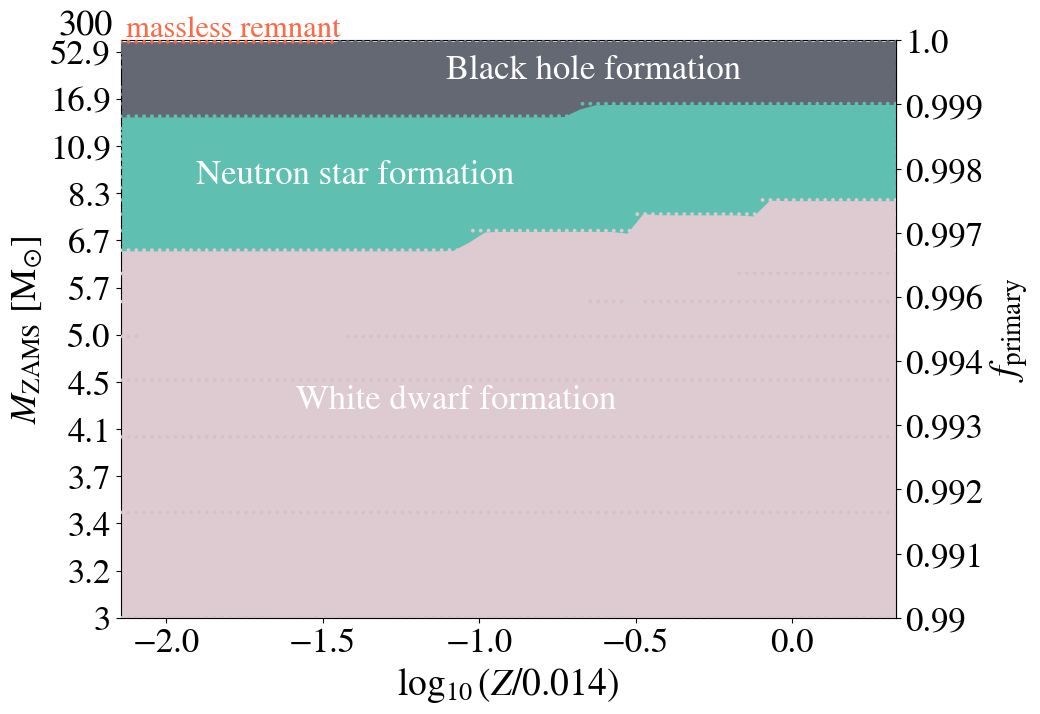

In [7]:
# Colors
color_dict = {15: '#ff6842', 
              14: '#646873', 
              13: '#5FC0B2',
              12: '#decad1',
              11: '#cfc6c2',
              11: '#dbd0d4'}

#   'BHNS': '#377CB7',#'#4D7DAF', #'#e8485a', 

metallicities = np.logspace(-4, np.log10(0.03), num=50)
Zsun = 0.014

###############
fig, ax = plt.subplots(figsize = (10,7.5))

# First define new y values
new_Y_ticks = np.linspace(0, 1, len(Y_ticks))

###################
# fill with interpolated
# WD
WD_max_mzams = interp_funcs[12](metallicities)
ax.fill_between(np.log10(metallicities/Zsun), y1 = 0, y2= np.interp(WD_max_mzams, Y_ticks, new_Y_ticks),  
            label = 'WD', color = color_dict[12])

# NS
NS_max_mzams = interp_funcs[13](metallicities)
ax.fill_between(np.log10(metallicities/Zsun), y1 = np.interp(WD_max_mzams, Y_ticks, new_Y_ticks), y2= np.interp(NS_max_mzams, Y_ticks, new_Y_ticks),  
            label = 'NS', color = color_dict[13])

# BH
BH_max_mzams = interp_funcs[14](metallicities)
ax.fill_between(np.log10(metallicities/Zsun), y1 = np.interp(NS_max_mzams, Y_ticks, new_Y_ticks), y2= np.interp(BH_max_mzams, Y_ticks, new_Y_ticks),  
            label = 'BH', color = color_dict[14])

##########
# scatter plot 
col_map_table = Stellar_Type_table
# newcmp = ListedColormap(sns.color_palette("rainbow", len(col_map_table))) 
newcmp = ListedColormap(['#d4d2d2','#cfc6c2','#decad1','#5FC0B2','#646873','#ff6842',]) 


# map your old y values to the new y values using np.interp
im = ax.scatter(np.log10(ALL_SYS['Metallicity@ZAMS(1)']/Zsun), np.interp(ALL_SYS['Mass@ZAMS(1)'], Y_ticks, new_Y_ticks), 
                c = ALL_SYS['Stellar_Type(1)'], cmap = newcmp,  marker = 'o', 
                vmin = min(col_map_table['indices']) -0.5, vmax= max(col_map_table['indices']) + 0.5, s = 3, zorder = 10)

# Create the colorbar
# cb = plt.colorbar(im, ticks=col_map_table['indices'])
# cb.ax.set_yticklabels(col_map_table['types'], size = 17)

##########
# Add text to figure
# fig.text(0.15, 0.85, 'massless remnant', ha='left', va='center', c = 'white', size = 17)
fig.text(0.13, 0.895, 'massless remnant', ha='left', va='center', c = '#ff6842', size = 22)
fig.text(0.45, 0.84, 'Black hole formation', ha='left', va='center', c = 'white')
fig.text(0.2, 0.7, 'Neutron star formation', ha='left', va='center', c = 'white')
fig.text(0.3, 0.4, 'White dwarf formation', ha='left', va='center', c = 'white')

##########
# Set the y-ticks and y-ticklabels
yticks = new_Y_ticks[::150]
yticklabels = [np.round(y,1) for y in Y_ticks[::150]]
#I also want to show 150 
# yticks = np.append(yticks, np.interp(150, Y_ticks, new_Y_ticks))
# yticklabels.append(150) 
#
ax.set_yticks(yticks)
ax.yaxis.set_ticklabels(yticklabels) # change the ticks' names to y
#Manually add 150
ax.text(-0.01, 1.01, '300', ha='right', transform=ax.transAxes, fontsize = 26)

ax.set_ylim(new_Y_ticks[0], new_Y_ticks[-1])

##########
# Make a right axis for f_primary
r_ax = ax.secondary_yaxis('right')

# Set the ticks and tick labels  # following a Salpeter IMF, up from 3 = (1-0.01) %, and 300 = 100%
r_ax.yaxis.set_ticks(np.linspace(0, 1, 10))
r_ax.yaxis.set_ticklabels(np.around(np.linspace(0.99, 1, 10),3 )  )

r_ax.set_ylabel('$f_{\mathrm{primary}}$', size = 28)

#######
# more plotting values
ax.set_xlim(np.log10(1e-4/0.014), np.log10(0.03/0.014))
ax.set_xlabel('$\log_{10}$($Z/0.014$)', fontsize = 27)
ax.set_ylabel('$M_{\mathrm{ZAMS}}$ [M$_{\odot}$]', size =26)

# ax.legend()
plt.savefig(f'../Figures/M_ZAMS_Type_perZ_{sim_name}.pdf',bbox_inches='tight')
plt.show()
